In [808]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import nsepython as nse
import datetime 
import time
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error



In [809]:
# Inputs
# Date input
prediction_date = datetime.date(year=2025, month=8, day=8)
from_date = datetime.date(year=2014,month=1,day=1).strftime("%Y-%m-%d")
to_date = (prediction_date).strftime("%Y-%m-%d")
print(datetime.datetime.now(),' : Date inputs taken!')

print(from_date)

2025-08-08 00:20:29.714520  : Date inputs taken!
2014-01-01


In [810]:
df = yf.download('^NSEI',start=from_date,end=to_date)
print(datetime.datetime.now(),' : Data downloaded!')


/tmp/ipykernel_5163/4025041859.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('^NSEI',start=from_date,end=to_date)
[*********************100%***********************]  1 of 1 completed

2025-08-08 00:20:30.957021  : Data downloaded!


In [811]:
df

Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2014-01-02,6221.149902,6358.299805,6211.299805,6301.250000,158100
2014-01-03,6211.149902,6221.700195,6171.250000,6194.549805,139000
2014-01-06,6191.450195,6224.700195,6170.250000,6220.850098,118300
2014-01-07,6162.250000,6221.500000,6144.750000,6203.899902,138600
2014-01-08,6174.600098,6192.100098,6160.350098,6178.049805,146900
...,...,...,...,...,...
2025-08-01,24565.349609,24784.150391,24535.050781,24734.900391,263400
2025-08-04,24722.750000,24736.250000,24554.000000,24596.050781,259300


In [812]:
# Column renaming and feature selectio8n
df.columns = ['Open','High','Low','Close','Volume']
df.drop('Volume',axis=1,inplace=True)
print(datetime.datetime.now(),' : Columns renamed and fetures selecetd') 

2025-08-08 00:20:30.972825  : Columns renamed and fetures selecetd


In [813]:
df

,Open,High,Low,Close
Date,,,,
2014-01-02,6221.149902,6358.299805,6211.299805,6301.250000
2014-01-03,6211.149902,6221.700195,6171.250000,6194.549805
2014-01-06,6191.450195,6224.700195,6170.250000,6220.850098
2014-01-07,6162.250000,6221.500000,6144.750000,6203.899902
2014-01-08,6174.600098,6192.100098,6160.350098,6178.049805
...,...,...,...,...
2025-08-01,24565.349609,24784.150391,24535.050781,24734.900391
2025-08-04,24722.750000,24736.250000,24554.000000,24596.050781
2025-08-05,24649.550781,24733.099609,24590.300781,24720.250000


In [814]:
# feature genration
for i in ['Open','High','Low','Close']:
    for j in ['Open','High','Low','Close']:
        df[f'{j}Wp{i}'] = round((df[j] - df[i].shift(1))/df[j]*100,2)

df['CloseWcOpen'] = round((df['Open'] - df['Close'])/df['Open']*100,2)



for i in ['Close','Open']:
    for j in ['High','Low']:
        df[f'Abs{i}Wc{j}'] = round(abs(df[i] - df[j])/df[i]*100,2)

cols = df.columns.tolist()

for i in [3,5,9,20,50,100]:
    for j in cols:
        df[f'rm{i}_{j}'] = df[j].rolling(i).mean()
        df[f'rstd{i}_{j}'] = df[j].rolling(i).std()
        


df.drop(['High','Open','Low','Close'],axis=1,inplace=True)
df.dropna(inplace=True)

        
print(datetime.datetime.now(),' : Features generated and cleaned!')

2025-08-08 00:20:31.098298  : Features generated and cleaned!


/tmp/ipykernel_5163/2432429638.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'rm{i}_{j}'] = df[j].rolling(i).mean()
/tmp/ipykernel_5163/2432429638.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'rstd{i}_{j}'] = df[j].rolling(i).std()
/tmp/ipykernel_5163/2432429638.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [815]:
df['CloseWpClose']

Date
2014-06-03    1.51
2014-06-04    0.57
2014-06-05   -0.24
2014-06-06    1.62
2014-06-09    1.31
              ... 
2025-08-01    0.37
2025-08-04   -0.56
2025-08-05    0.50
2025-08-06   -0.32
2025-08-07   -0.72
Name: CloseWpClose, Length: 2750, dtype: float64

In [ ]:
# Train test split
df['NxtCloseWpClose'] = df['CloseWpClose'].shift(-1)
df['NxtOpenWpClose'] = df['OpenWpClose'].shift(-1)
df['NxtOpenWpOpen'] = df['OpenWpOpen'].shift(-1)
df['NxtOpenWpHigh'] = df['OpenWpHigh'].shift(-1)
df['NxtOpenWpLow'] = df['OpenWpLow'].shift(-1)  

X_train, X_test, y_train, y_test = train_test_split(df.drop('NxtCloseWpClose',axis=1),
                                                    df['NxtCloseWpClose'],
                                                    test_size=0.2,
                                                    shuffle=False)


X_test = X_test.iloc[:-1]
y_test = y_test.iloc[:-1]


print(datetime.datetime.now(),' : Train test split done')


2025-08-08 00:20:31.130105  : Train test split done


/tmp/ipykernel_5163/1379771184.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NxtCloseWpClose'] = df['CloseWpClose'].shift(-1)
/tmp/ipykernel_5163/1379771184.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NxtOpenWpClose'] = df['OpenWpClose'].shift(-1)
/tmp/ipykernel_5163/1379771184.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

In [817]:
# Model initiated
model = XGBRegressor()
print(datetime.datetime.now(),' : XG Booster regression model initiated with default parameters')


2025-08-08 00:20:31.134754  : XG Booster regression model initiated with default parameters


In [818]:
# Model fitting
model.fit(X_train,y_train)
print(datetime.datetime.now(),' : Model fitted!')


2025-08-08 00:20:34.327864  : Model fitted!


In [819]:
# Prediction for test set
y_pred = pd.Series(model.predict(X_test),index=X_test.index)
print(datetime.datetime.now(),' : Predictions made for test set!')


2025-08-08 00:20:34.350015  : Predictions made for test set!


In [820]:
# Rmse calculation
rmse = root_mean_squared_error(y_test,y_pred)
print(datetime.datetime.now(),' : Root mean squared error calculated!')

2025-08-08 00:20:34.357163  : Root mean squared error calculated!


In [821]:
# Rmse display
print("Root Mean Squared Error :")
print("For given test data")
print("on an average")
print(f"predicted value falls within +/- {rmse:.2f} % range of actual index price")

Root Mean Squared Error :
For given test data
on an average
predicted value falls within +/- 0.51 % range of actual index price


In [822]:
# Prediction on given date 
result = y_pred.iloc[-1:]
result = float(result.values[0])
print(datetime.datetime.now(),' : Prediction done!')
print('Result : ')
print(f"% change in close w.r.t. prev close is likely to be {result:.2f} % on {prediction_date}")

2025-08-08 00:20:34.367097  : Prediction done!
Result : 
% change in close w.r.t. prev close is likely to be 0.09 % on 2025-08-08


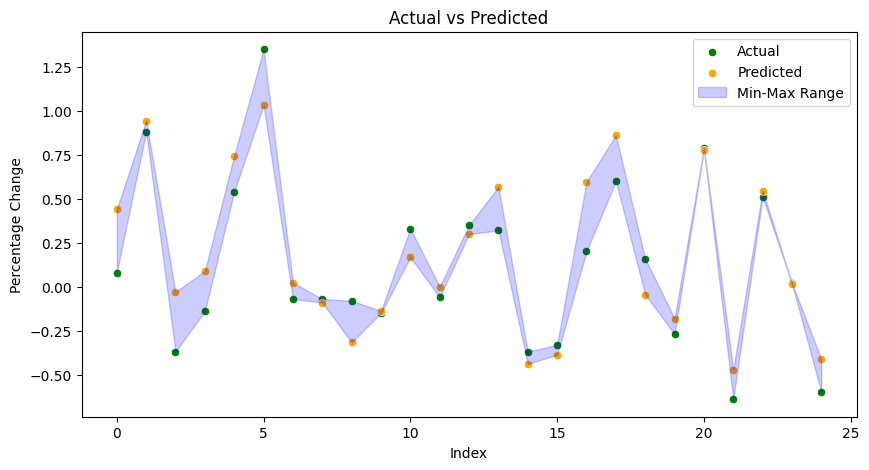

2025-08-08 00:20:34.494066  : latest 25 predicted and corresponding actual avlues plotted! 


In [823]:
# Prediction for last n values
n = 25
pred_table = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
pred_table.reset_index(inplace=True)
data = pred_table.reset_index()[:n]
plt.figure(figsize=(10,5))
sns.scatterplot(x=data.index,y=data['Actual'],color='green',label='Actual')
sns.scatterplot(x=data.index,y=data['Predicted'],color='orange',label='Predicted')
y_min = []
y_max = []
for i in range(len(data)):
    y_min.append(min(data['Actual'][i],data['Predicted'][i]))
    y_max.append(max(data['Actual'][i],data['Predicted'][i]))
plt.fill_between(data.index,y_min,y_max,alpha=0.2,color='blue',label='Min-Max Range')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Percentage Change')
plt.show()
print(datetime.datetime.now(),f' : latest {n} predicted and corresponding actual avlues plotted! ')

In [824]:
# Prediction table for test data 

pred_table = pd.DataFrame()
pred_table['Actual']= y_test
pred_table['Predicted'] = y_pred
print(datetime.datetime.now(),' : Prediction table for test data created!') 
pred_table

2025-08-08 00:20:34.499943  : Prediction table for test data created!


,Actual,Predicted
Date,,
2023-05-19,0.08,0.439910
2023-05-22,0.88,0.944401
2023-05-23,-0.37,-0.029909
2023-05-24,-0.14,0.088763
2023-05-25,0.54,0.745269
...,...,...
2025-07-31,0.37,0.654751
2025-08-01,-0.56,-0.493555
2025-08-04,0.50,1.035937
